In [237]:
import pandas as pd
import numpy as np
import scipy
import datetime
import os
import re
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
font = {"family":"IPAexGothic"}
mpl.rc('font', **font)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn import metrics, preprocessing
from datetime import datetime, date
from collections import defaultdict
import optuna
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore") 

In [238]:
#96ut.comからIPOデータを取得(2001年から2019年、1794件)
ipo_urls = ['https://96ut.com/ipo/list.php?year={}'.format(str(i)) for i in range(2001, 2020)]
df_ipo = pd.DataFrame(columns = ["code","銘柄名","主幹","上場","市場","想定(仮条件)","公募","吸収金額","評価","初値","(騰落率)損益","現在値(差分)"])
for urls in ipo_urls:
    df_ipo = df_ipo.append(pd.read_html(urls))

In [239]:
#indexを銘柄コードに
df_ipo = df_ipo.set_index('code')
#確認
df_ipo.head()

,銘柄名,主幹,上場,市場,想定(仮条件),公募,吸収金額,評価,初値,(騰落率)損益,現在値(差分)
code,,,,,,,,,,,
4334,ユークス,日興,12/21,NJS,-(),880,8.80億,-(),950,"(+8.0%) +70,000円",627 分割 2倍 (+304)
8902,パシフィックホールディングス,野村,12/21,JQ,-(),250000,5.12億,-(),650000,"(+160.0%) +400,000円","95 (-649,905)"
6738,東研,みずほ,12/21,JQ,-(),600,5.10億,-(),650,"(+8.3%) +50,000円",-
9447,丸紅テレコム,日興,12/20,東2,-(),93000,19.5億,-(),66500,"(-28.5%) -26,500円",-
4335,アイ・ピー・エス,三菱,12/20,JQ,-(),360000,2.16億,-(),1350000,"(+275.0%) +990,000円","951 分割 500倍 (-874,500)"


In [240]:
#幹事
#lead = df_ipo['主幹'].value_counts()
#print(lead)

In [241]:
#主幹事が多いほど期待が大きい⇒主幹事数のカラム追加
#print(df_ipo.query('主幹 == "野村 三菱 大和 みずほ 日興 岡三 東海東京"'))

In [242]:
#上場日
#listed_month = df_ipo['上場'].str[:2].value_counts()
#print(listed_month)

In [243]:
#plt.plot(listed_month.sort_index())

In [244]:
#市場⇒東１以下はまとめていいかな
#market = df_ipo['市場'].value_counts()
#print(market)

In [245]:
#想定(仮条件)⇒要加工
#tentatively = df_ipo['想定(仮条件)'].value_counts()
#print(tentatively)

In [246]:
#公募
#public = df_ipo['公募'].value_counts()
#print(public)

In [247]:
#吸収金額
#absorption = df_ipo['吸収金額'].str.strip('億').value_counts()
#print(absorption)

In [248]:
#評価
#evaluation = df_ipo['評価'].value_counts()
#print(evaluation)

In [249]:
#初値⇒-になっているものは除く
#opening = df_ipo['初値'].value_counts()
#print(opening)

In [250]:
#損益⇒加工めんどいし初値を公募価格で割ればいいか
#pl = df_ipo['(騰落率)損益'].value_counts()
#print(pl)

In [251]:
#データ加工
#'(騰落率)損益', '現在値(差分)'を削除
dataset = df_ipo.drop(columns=['(騰落率)損益', '現在値(差分)','銘柄名'])

In [252]:
#初値が-になっているものを削除
dataset = dataset[dataset["初値"] != "-"]

In [253]:
#主幹事数のカラムを追加
def count_syukan(x):
    y = int(str(x).count(" "))+1
    return y

In [254]:
#主幹事数のカラムを追加
dataset["主幹事数"] = dataset['主幹'].apply(count_syukan)
dataset= dataset.drop("主幹",axis=1)

In [255]:
#上場月カラム追加
dataset["上場月"] = dataset['上場'].str[:2]
dataset = dataset.drop("上場",axis=1)

In [256]:
#市場をまとめる
def func_cate(x):
    if x == "東M":
        return x
    elif x == "JQ":
        return x
    elif x == "東2":
        return x
    elif x == "JQS":
        return x
    elif x == "東1":
        return x
    else:
        return 'その他'

dataset['市場'] =dataset['市場'].apply(func_cate)

In [258]:
#仮条件を抽出
dataset = pd.concat([dataset, dataset['想定(仮条件)'].apply(lambda st: st[st.find("(")+1:st.find(")")]).str.split('-', expand=True)], axis=1).drop('想定(仮条件)', axis=1)

In [259]:
dataset.rename(columns={0: '仮条件下限', 1: '仮条件上限'}, inplace=True)
dataset=dataset.dropna()

In [260]:
dataset["仮条件下限"] = dataset["仮条件下限"].str.replace('k', '000')
dataset["仮条件下限"] = dataset["仮条件下限"].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
dataset["仮条件上限"] = dataset["仮条件上限"].str.replace('k', '000')
dataset["仮条件上限"] = dataset["仮条件上限"].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))

In [261]:
dataset["仮条件幅"] = dataset["仮条件上限"] - dataset["仮条件下限"]

In [262]:
#公募をintに
dataset['公募'] = dataset['公募'].astype(int)

In [263]:
#吸収金額をfloatに
dataset['吸収金額'] = dataset['吸収金額'].str.strip('億').astype(float)

In [264]:
#初値をintに
dataset["初値"] = dataset["初値"].astype(int)

In [265]:
#上場市場評価をone hot encoding
#dataset = pd.get_dummies(dataset, drop_first=True,columns=["上場月","市場","評価"])
#カテゴリに指定
cate_cols = ["上場月","市場","評価"]

In [266]:
#カテゴリに変換
for column in cate_cols:
    le = preprocessing.LabelEncoder()
    le.fit(dataset[column])
    dataset[column] = le.transform(dataset[column])
    dataset[column] = dataset[column].astype('category')
    
dataset.head()

,市場,公募,吸収金額,評価,初値,主幹事数,上場月,仮条件下限,仮条件上限,仮条件幅
code,,,,,,,,,,
8952,2,525000,840.0,0,535000,1,8,475000,525000,50000
8951,2,625000,625.0,0,625000,1,8,550000,625000,75000
2347,5,170000,5.1,0,170000,1,11,140000,170000,30000
2756,0,400,3.2,0,450,1,11,400,500,100
8910,0,130000,2.8,0,138000,1,11,120000,150000,30000


In [267]:
#危険シグナルラベルを作る
def kiken_label(x):
    if  x > 0:
        return 0
    else:
        return 1

dataset["危険シグナル"] = dataset["初値"] - dataset["公募"]
dataset["危険シグナル"] = dataset["危険シグナル"].apply(kiken_label)
dataset = dataset.drop(columns=['初値'])

In [268]:
#特徴量追加
dataset["公募-仮上限"] = dataset['公募'] - dataset["仮条件上限"]
dataset["株数"] = dataset['吸収金額'] / dataset["公募"] * 100000000

In [269]:
#target

train = dataset[:1200]
test = dataset[1200:]

In [270]:
df_train_x = train.drop(["危険シグナル"], axis=1)
df_train_y = train["危険シグナル"]
df_test_x = test.drop(["危険シグナル"], axis=1)
df_test_y = test["危険シグナル"]

# 説明変数リスト取得
train_columns = list(df_train_x.columns)

# 目的変数の比率を基に重みを作成
total_0_record = train["危険シグナル"].value_counts()[0]
total_1_record = train["危険シグナル"].value_counts()[1]
obj_weight  = total_0_record / total_1_record * 0.2

In [271]:
# パラメータの履歴保存
def objectives(trial):
    skf = StratifiedKFold(
        n_splits=3, # Number of folds. Must be at least 2.
        shuffle=True # Whether to shuffle each stratification of the data before splitting into batches.
    )

    boost_rounds = []
    score = []

    for train_index, test_index in skf.split(df_train_x, df_train_y):
        _train_x, _test_x, _train_y, _test_y = df_train_x.iloc[train_index], df_train_x.iloc[test_index], df_train_y.iloc[train_index], df_train_y.iloc[test_index]

        train_xd = lgb.Dataset(_train_x, label=_train_y, feature_name=train_columns, categorical_feature=cate_cols, weight=_train_y * obj_weight + 1)
        test_xd = lgb.Dataset(_test_x, label=_test_y, feature_name=train_columns, categorical_feature=cate_cols, reference=train_xd, weight=_test_y * obj_weight + 1)

        dict_param = {
            "boosting_type": trial.suggest_categorical("boosting", ["gbdt", "dart", "goss"]),
            "objective": "xentropy",
            "metric": "xentropy",
            "num_leaves": trial.suggest_int("num_leaves", 5, 80),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 300),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
            "drop_rate": trial.suggest_loguniform("drop_rate", 0.1, 0.8),
            "feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 0.9),
            #"obj_weight": trial.suggest_uniform("obj_weight", 0.01, 0.05),
            "verbose" : 0
        }
        if dict_param["boosting_type"] == "dart":
            dict_param["drop_rate"] = trial.suggest_loguniform("drop_rate", 1e-8, 1.0)
            dict_param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)
        if dict_param["boosting_type"] == "goss":
            dict_param["top_rate"] = trial.suggest_uniform("top_rate", 0.0, 1.0)
            dict_param["other_rate"] = trial.suggest_uniform("other_rate", 0.0, 1.0 - dict_param["top_rate"])
        
        model = lgb.train(
        dict_param,
        train_xd,
        num_boost_round=10000,
        valid_sets=test_xd,
        early_stopping_rounds=300,
        verbose_eval=False
        )
       
        # 精度評価用のスコア計算
        pred_train = model.predict(_train_x)
        pred_test = model.predict(_test_x)
        logloss_train = metrics.log_loss( _train_y, pred_train)
        logloss_test = metrics.log_loss(_test_y, pred_test)
        f1_train = max([metrics.f1_score(_train_y, preprocessing.binarize(X=pred_train.reshape(1, -1), threshold=(i * 0.01))[0]) for i in range(1, 100)])
        f1_test = max([metrics.f1_score(_test_y, preprocessing.binarize(X=pred_test.reshape(1, -1), threshold=(i * 0.01))[0]) for i in range(1, 100)])
        boost_round = model.best_iteration
        
        # スコアの記録
        trial.set_user_attr("logloss_train", logloss_train)
        trial.set_user_attr("logloss_test", logloss_test)
        trial.set_user_attr("f1_train", f1_train)
        trial.set_user_attr("f1_test", f1_test)
        trial.set_user_attr("boost_round", boost_round)

        
        print("trial_id", trial.trial_id,  "logloss_train", logloss_train, "logloss_test", logloss_test, "boost_round", boost_round, "f1_train", f1_train, "f1_test", f1_test)
        
        return logloss_test

In [272]:
#学習開始
study = optuna.create_study()
study.optimize(objectives, n_trials=100)

trial_id 0 logloss_train 0.44357055084165226 logloss_test 0.44877607211463977 boost_round 1484 f1_train 0.48910411622276034 f1_test 0.48076923076923084


[I 2019-04-22 10:55:13,094] Finished a trial resulted in value: 0.44877607211463977. Current best value is 0.44877607211463977 with parameters: {'boosting': 'gbdt', 'num_leaves': 28, 'min_data_in_leaf': 181, 'learning_rate': 0.010477248235854756, 'drop_rate': 0.39030552661280327, 'feature_fraction': 0.18095715709870977}.


trial_id 1 logloss_train 0.39399446263302584 logloss_test 0.455945283652373 boost_round 296 f1_train 0.5619834710743802 f1_test 0.4513274336283186


[I 2019-04-22 10:55:13,467] Finished a trial resulted in value: 0.455945283652373. Current best value is 0.44877607211463977 with parameters: {'boosting': 'gbdt', 'num_leaves': 28, 'min_data_in_leaf': 181, 'learning_rate': 0.010477248235854756, 'drop_rate': 0.39030552661280327, 'feature_fraction': 0.18095715709870977}.


trial_id 2 logloss_train 0.4434827944176512 logloss_test 0.46121518384363763 boost_round 403 f1_train 0.49048625792811845 f1_test 0.4663677130044843


[I 2019-04-22 10:55:13,834] Finished a trial resulted in value: 0.46121518384363763. Current best value is 0.44877607211463977 with parameters: {'boosting': 'gbdt', 'num_leaves': 28, 'min_data_in_leaf': 181, 'learning_rate': 0.010477248235854756, 'drop_rate': 0.39030552661280327, 'feature_fraction': 0.18095715709870977}.


trial_id 3 logloss_train 0.31218364487178146 logloss_test 0.4014946409677397 boost_round 366 f1_train 0.7023411371237458 f1_test 0.4941176470588235


[I 2019-04-22 10:55:14,278] Finished a trial resulted in value: 0.4014946409677397. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 4 logloss_train 0.45169094872729215 logloss_test 0.48158884406777536 boost_round 109 f1_train 0.503562945368171 f1_test 0.4291845493562232


[I 2019-04-22 10:55:14,590] Finished a trial resulted in value: 0.48158884406777536. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 5 logloss_train 0.44086543241565646 logloss_test 0.47053058732920366 boost_round 1158 f1_train 0.5120350109409191 f1_test 0.45544554455445546


[I 2019-04-22 10:55:15,129] Finished a trial resulted in value: 0.47053058732920366. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 6 logloss_train 0.34314109576919294 logloss_test 0.4218278516824532 boost_round 117 f1_train 0.6778523489932885 f1_test 0.497816593886463


[I 2019-04-22 10:55:15,550] Finished a trial resulted in value: 0.4218278516824532. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 7 logloss_train 0.6385466651360545 logloss_test 0.6428466061268573 boost_round 0 f1_train 0.42332613390928725 f1_test 0.45283018867924524


[I 2019-04-22 10:55:27,297] Finished a trial resulted in value: 0.6428466061268573. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 8 logloss_train 0.42852327445373756 logloss_test 0.4700444569946828 boost_round 643 f1_train 0.515625 f1_test 0.4571428571428572


[I 2019-04-22 10:55:27,746] Finished a trial resulted in value: 0.4700444569946828. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 9 logloss_train 0.43943103394963445 logloss_test 0.48228773905427097 boost_round 153 f1_train 0.5213032581453634 f1_test 0.40540540540540543


[I 2019-04-22 10:55:28,060] Finished a trial resulted in value: 0.48228773905427097. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 10 logloss_train 0.3883164147781474 logloss_test 0.5007736700954534 boost_round 0 f1_train 0.5988700564971752 f1_test 0.4155844155844156


[I 2019-04-22 10:55:55,034] Finished a trial resulted in value: 0.5007736700954534. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 11 logloss_train 0.31852743945827383 logloss_test 0.4632952362715371 boost_round 29 f1_train 0.8695652173913044 f1_test 0.4306220095693779


[I 2019-04-22 10:55:55,506] Finished a trial resulted in value: 0.4632952362715371. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 12 logloss_train 0.41502619506090693 logloss_test 0.4949547697859453 boost_round 0 f1_train 0.5403899721448469 f1_test 0.43076923076923074


[I 2019-04-22 10:56:22,090] Finished a trial resulted in value: 0.4949547697859453. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 13 logloss_train 0.3577574736534999 logloss_test 0.432626203732358 boost_round 48 f1_train 0.6413793103448275 f1_test 0.5029940119760478


[I 2019-04-22 10:56:22,423] Finished a trial resulted in value: 0.432626203732358. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 14 logloss_train 0.4336977906220756 logloss_test 0.471921587396765 boost_round 161 f1_train 0.5263157894736842 f1_test 0.44166666666666665


[I 2019-04-22 10:56:22,809] Finished a trial resulted in value: 0.471921587396765. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 15 logloss_train 0.3025990544666992 logloss_test 0.4592264193129795 boost_round 27 f1_train 0.9125000000000001 f1_test 0.45


[I 2019-04-22 10:56:23,420] Finished a trial resulted in value: 0.4592264193129795. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 16 logloss_train 0.3189503341103071 logloss_test 0.4693650603303931 boost_round 0 f1_train 0.8417508417508416 f1_test 0.4519230769230769


[I 2019-04-22 10:57:14,639] Finished a trial resulted in value: 0.4693650603303931. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 17 logloss_train 0.33934321765976727 logloss_test 0.4344747854007785 boost_round 115 f1_train 0.6346863468634686 f1_test 0.5084745762711864


[I 2019-04-22 10:57:15,006] Finished a trial resulted in value: 0.4344747854007785. Current best value is 0.4014946409677397 with parameters: {'boosting': 'goss', 'num_leaves': 42, 'min_data_in_leaf': 60, 'learning_rate': 0.030819071514872436, 'drop_rate': 0.5998921527562356, 'feature_fraction': 0.45166351621283274, 'top_rate': 0.5414972207886624, 'other_rate': 0.14468699932116735}.


trial_id 18 logloss_train 0.33009436403875875 logloss_test 0.3939885827649386 boost_round 158 f1_train 0.700280112044818 f1_test 0.5820895522388059


[I 2019-04-22 10:57:15,451] Finished a trial resulted in value: 0.3939885827649386. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 19 logloss_train 0.3701515700995156 logloss_test 0.43498654184937613 boost_round 259 f1_train 0.6145251396648046 f1_test 0.5082872928176796


[I 2019-04-22 10:57:15,859] Finished a trial resulted in value: 0.43498654184937613. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 20 logloss_train 0.3172332468710925 logloss_test 0.4372692156272312 boost_round 76 f1_train 0.7515923566878981 f1_test 0.48837209302325574


[I 2019-04-22 10:57:16,364] Finished a trial resulted in value: 0.4372692156272312. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 21 logloss_train 0.3620734816815908 logloss_test 0.4304761158749665 boost_round 57 f1_train 0.622093023255814 f1_test 0.4780487804878049


[I 2019-04-22 10:57:16,767] Finished a trial resulted in value: 0.4304761158749665. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 22 logloss_train 0.42398159675472513 logloss_test 0.4660541291121994 boost_round 322 f1_train 0.5162907268170426 f1_test 0.47457627118644063


[I 2019-04-22 10:57:17,163] Finished a trial resulted in value: 0.4660541291121994. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 23 logloss_train 0.3988116061309595 logloss_test 0.4591226907952018 boost_round 246 f1_train 0.572192513368984 f1_test 0.4659090909090909


[I 2019-04-22 10:57:17,554] Finished a trial resulted in value: 0.4591226907952018. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 24 logloss_train 0.3290941638925716 logloss_test 0.40700164434588904 boost_round 170 f1_train 0.7278287461773699 f1_test 0.524822695035461


[I 2019-04-22 10:57:18,051] Finished a trial resulted in value: 0.40700164434588904. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 25 logloss_train 0.4033779965781947 logloss_test 0.46528442944971243 boost_round 498 f1_train 0.5321100917431192 f1_test 0.46721311475409844


[I 2019-04-22 10:57:18,506] Finished a trial resulted in value: 0.46528442944971243. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 26 logloss_train 0.40720043157522967 logloss_test 0.45408407828916225 boost_round 0 f1_train 0.6128133704735377 f1_test 0.48704663212435234


[I 2019-04-22 10:58:03,254] Finished a trial resulted in value: 0.45408407828916225. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 27 logloss_train 0.4007718339786561 logloss_test 0.4919140181692586 boost_round 223 f1_train 0.5484764542936288 f1_test 0.4172661870503597


[I 2019-04-22 10:58:03,619] Finished a trial resulted in value: 0.4919140181692586. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 28 logloss_train 0.3660185797353602 logloss_test 0.44300661440799294 boost_round 235 f1_train 0.6037735849056604 f1_test 0.509090909090909


[I 2019-04-22 10:58:04,066] Finished a trial resulted in value: 0.44300661440799294. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 29 logloss_train 0.34275494070796686 logloss_test 0.432244527487134 boost_round 66 f1_train 0.6862170087976539 f1_test 0.4973544973544973


[I 2019-04-22 10:58:04,446] Finished a trial resulted in value: 0.432244527487134. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 30 logloss_train 0.4263167643230653 logloss_test 0.4812284931838468 boost_round 268 f1_train 0.5230024213075061 f1_test 0.41509433962264153


[I 2019-04-22 10:58:04,815] Finished a trial resulted in value: 0.4812284931838468. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 31 logloss_train 0.3104777259892915 logloss_test 0.40475661505176436 boost_round 0 f1_train 0.7380952380952381 f1_test 0.5444444444444444


[I 2019-04-22 10:58:45,490] Finished a trial resulted in value: 0.40475661505176436. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 32 logloss_train 0.42682249488646895 logloss_test 0.46395791267311576 boost_round 1412 f1_train 0.502415458937198 f1_test 0.4734299516908213


[I 2019-04-22 10:58:46,184] Finished a trial resulted in value: 0.46395791267311576. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 33 logloss_train 0.44261111863065944 logloss_test 0.43355408923120325 boost_round 310 f1_train 0.48760330578512395 f1_test 0.4953271028037384


[I 2019-04-22 10:58:46,537] Finished a trial resulted in value: 0.43355408923120325. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 34 logloss_train 0.4542396704830759 logloss_test 0.4860445667318746 boost_round 836 f1_train 0.4713375796178344 f1_test 0.4083044982698962


[I 2019-04-22 10:58:47,022] Finished a trial resulted in value: 0.4860445667318746. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 35 logloss_train 0.4010520669436104 logloss_test 0.44324176322026826 boost_round 205 f1_train 0.5657568238213398 f1_test 0.4830508474576271


[I 2019-04-22 10:58:47,494] Finished a trial resulted in value: 0.44324176322026826. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 36 logloss_train 0.4356147137436737 logloss_test 0.47023710970825977 boost_round 66 f1_train 0.5138539042821159 f1_test 0.4077669902912622


[I 2019-04-22 10:58:47,795] Finished a trial resulted in value: 0.47023710970825977. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 37 logloss_train 0.3121945120912135 logloss_test 0.44025931462876355 boost_round 418 f1_train 0.7668711656441718 f1_test 0.4390243902439024


[I 2019-04-22 10:58:48,417] Finished a trial resulted in value: 0.44025931462876355. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 38 logloss_train 0.0014745717665645116 logloss_test 1.1657982618412002 boost_round 0 f1_train 1.0 f1_test 0.46875


[I 2019-04-22 10:59:10,046] Finished a trial resulted in value: 1.1657982618412002. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 39 logloss_train 0.4456723315702596 logloss_test 0.4600120735390903 boost_round 189 f1_train 0.47654784240150094 f1_test 0.4700460829493088


[I 2019-04-22 10:59:10,400] Finished a trial resulted in value: 0.4600120735390903. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 40 logloss_train 0.43514935596295046 logloss_test 0.45855426936179366 boost_round 1189 f1_train 0.49885583524027455 f1_test 0.4787234042553192


[I 2019-04-22 10:59:10,911] Finished a trial resulted in value: 0.45855426936179366. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 41 logloss_train 0.10112442535182795 logloss_test 0.6382983993025467 boost_round 0 f1_train 0.9869281045751634 f1_test 0.3969465648854962


[I 2019-04-22 10:59:24,773] Finished a trial resulted in value: 0.6382983993025467. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 42 logloss_train 0.3244707237625155 logloss_test 0.46019083500974617 boost_round 124 f1_train 0.8686868686868687 f1_test 0.4264705882352941


[I 2019-04-22 10:59:25,244] Finished a trial resulted in value: 0.46019083500974617. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 43 logloss_train 0.32669384661729894 logloss_test 0.4397817709429458 boost_round 48 f1_train 0.70625 f1_test 0.4974093264248705


[I 2019-04-22 10:59:25,653] Finished a trial resulted in value: 0.4397817709429458. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 44 logloss_train 0.45403754585337686 logloss_test 0.48514011656095635 boost_round 213 f1_train 0.48898678414096913 f1_test 0.4245283018867924


[I 2019-04-22 10:59:25,993] Finished a trial resulted in value: 0.48514011656095635. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 45 logloss_train 0.419777060726278 logloss_test 0.47100455581077993 boost_round 204 f1_train 0.532967032967033 f1_test 0.45535714285714285


[I 2019-04-22 10:59:26,354] Finished a trial resulted in value: 0.47100455581077993. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 46 logloss_train 0.3908198901678286 logloss_test 0.4670529806353403 boost_round 0 f1_train 0.584795321637427 f1_test 0.4574468085106383


[I 2019-04-22 10:59:50,913] Finished a trial resulted in value: 0.4670529806353403. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 47 logloss_train 0.3494931998990862 logloss_test 0.41786000333362255 boost_round 196 f1_train 0.6388888888888888 f1_test 0.4941176470588235


[I 2019-04-22 10:59:51,341] Finished a trial resulted in value: 0.41786000333362255. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 48 logloss_train 0.4340346946906569 logloss_test 0.49736967746118477 boost_round 173 f1_train 0.522167487684729 f1_test 0.4251968503937008


[I 2019-04-22 10:59:51,678] Finished a trial resulted in value: 0.49736967746118477. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 49 logloss_train 0.4239457800153224 logloss_test 0.47010850930190723 boost_round 328 f1_train 0.5185185185185185 f1_test 0.44961240310077516


[I 2019-04-22 10:59:52,068] Finished a trial resulted in value: 0.47010850930190723. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 50 logloss_train 0.434326661611031 logloss_test 0.4747278946894877 boost_round 75 f1_train 0.5068493150684932 f1_test 0.42857142857142855


[I 2019-04-22 10:59:52,434] Finished a trial resulted in value: 0.4747278946894877. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 51 logloss_train 0.41295994474871117 logloss_test 0.4780688845195252 boost_round 0 f1_train 0.5346534653465346 f1_test 0.4463519313304721


[I 2019-04-22 11:00:07,568] Finished a trial resulted in value: 0.4780688845195252. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 52 logloss_train 0.3799099105722393 logloss_test 0.4958666272279867 boost_round 136 f1_train 0.7147766323024055 f1_test 0.3745819397993311


[I 2019-04-22 11:00:08,002] Finished a trial resulted in value: 0.4958666272279867. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 53 logloss_train 0.3267645605799878 logloss_test 0.39425034422202504 boost_round 214 f1_train 0.6946107784431138 f1_test 0.5153374233128833


[I 2019-04-22 11:00:08,445] Finished a trial resulted in value: 0.39425034422202504. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 54 logloss_train 0.3552600287400078 logloss_test 0.43309668165714554 boost_round 148 f1_train 0.652054794520548 f1_test 0.4685714285714286


[I 2019-04-22 11:00:08,828] Finished a trial resulted in value: 0.43309668165714554. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 55 logloss_train 0.3558112141801971 logloss_test 0.42671877113672896 boost_round 166 f1_train 0.6188679245283019 f1_test 0.4979591836734694


[I 2019-04-22 11:00:09,203] Finished a trial resulted in value: 0.42671877113672896. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 56 logloss_train 0.4117581435847259 logloss_test 0.46998612784875676 boost_round 313 f1_train 0.5769230769230769 f1_test 0.44933920704845814


[I 2019-04-22 11:00:09,657] Finished a trial resulted in value: 0.46998612784875676. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 57 logloss_train 0.27393808034612116 logloss_test 0.44810576597195617 boost_round 0 f1_train 0.8316831683168318 f1_test 0.5


[I 2019-04-22 11:01:00,058] Finished a trial resulted in value: 0.44810576597195617. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 58 logloss_train 0.36208802696034353 logloss_test 0.44864030838919705 boost_round 100 f1_train 0.6229508196721312 f1_test 0.4729064039408867


[I 2019-04-22 11:01:00,494] Finished a trial resulted in value: 0.44864030838919705. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 59 logloss_train 0.436418275824522 logloss_test 0.4646276458623945 boost_round 232 f1_train 0.5111111111111111 f1_test 0.4549356223175966


[I 2019-04-22 11:01:00,883] Finished a trial resulted in value: 0.4646276458623945. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 60 logloss_train 0.27401119829087267 logloss_test 0.4511299464146739 boost_round 91 f1_train 0.9034267912772586 f1_test 0.4397163120567376


[I 2019-04-22 11:01:01,440] Finished a trial resulted in value: 0.4511299464146739. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 61 logloss_train 0.40199694544447234 logloss_test 0.45753883606077306 boost_round 723 f1_train 0.5522788203753352 f1_test 0.4871794871794871


[I 2019-04-22 11:01:01,967] Finished a trial resulted in value: 0.45753883606077306. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 62 logloss_train 0.4348554259829578 logloss_test 0.46591029902260367 boost_round 0 f1_train 0.5370843989769821 f1_test 0.49565217391304356


[I 2019-04-22 11:01:30,725] Finished a trial resulted in value: 0.46591029902260367. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 63 logloss_train 0.3036949352862753 logloss_test 0.42127292485389484 boost_round 78 f1_train 0.759322033898305 f1_test 0.5197740112994351


[I 2019-04-22 11:01:31,116] Finished a trial resulted in value: 0.42127292485389484. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 64 logloss_train 0.3525400892883404 logloss_test 0.39890745608237377 boost_round 433 f1_train 0.6265060240963854 f1_test 0.548076923076923


[I 2019-04-22 11:01:31,650] Finished a trial resulted in value: 0.39890745608237377. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 65 logloss_train 0.3735876030185975 logloss_test 0.43954897928585135 boost_round 197 f1_train 0.6060606060606061 f1_test 0.5027932960893855


[I 2019-04-22 11:01:32,051] Finished a trial resulted in value: 0.43954897928585135. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 66 logloss_train 0.38657649816249245 logloss_test 0.45369012933457287 boost_round 692 f1_train 0.5813953488372092 f1_test 0.4728682170542636


[I 2019-04-22 11:01:32,616] Finished a trial resulted in value: 0.45369012933457287. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 67 logloss_train 0.3880618649836667 logloss_test 0.4534338090642889 boost_round 102 f1_train 0.6225165562913908 f1_test 0.45238095238095244


[I 2019-04-22 11:01:33,005] Finished a trial resulted in value: 0.4534338090642889. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 68 logloss_train 0.34823720896471133 logloss_test 0.44486098152909614 boost_round 197 f1_train 0.6822157434402333 f1_test 0.45051194539249156


[I 2019-04-22 11:01:33,479] Finished a trial resulted in value: 0.44486098152909614. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 69 logloss_train 0.3078438547304109 logloss_test 0.4256755637072016 boost_round 248 f1_train 0.713864306784661 f1_test 0.5088757396449705


[I 2019-04-22 11:01:33,954] Finished a trial resulted in value: 0.4256755637072016. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 70 logloss_train 0.3614729083808521 logloss_test 0.42827643036827096 boost_round 184 f1_train 0.6 f1_test 0.49


[I 2019-04-22 11:01:34,362] Finished a trial resulted in value: 0.42827643036827096. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 71 logloss_train 0.3533546277779894 logloss_test 0.4404531048030205 boost_round 75 f1_train 0.6948640483383686 f1_test 0.47715736040609136


[I 2019-04-22 11:01:34,844] Finished a trial resulted in value: 0.4404531048030205. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 72 logloss_train 0.33446162454626804 logloss_test 0.41499745912002484 boost_round 263 f1_train 0.6976744186046512 f1_test 0.5370370370370371


[I 2019-04-22 11:01:35,349] Finished a trial resulted in value: 0.41499745912002484. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 73 logloss_train 0.3444073880639374 logloss_test 0.39632826815733735 boost_round 356 f1_train 0.6385224274406334 f1_test 0.5359477124183005


[I 2019-04-22 11:01:35,892] Finished a trial resulted in value: 0.39632826815733735. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 74 logloss_train 0.3365619887487805 logloss_test 0.41635678839345414 boost_round 253 f1_train 0.6564885496183206 f1_test 0.4964539007092198


[I 2019-04-22 11:01:36,356] Finished a trial resulted in value: 0.41635678839345414. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 75 logloss_train 0.27926105090211684 logloss_test 0.40715349872653545 boost_round 62 f1_train 0.8832807570977917 f1_test 0.5540540540540541


[I 2019-04-22 11:01:36,980] Finished a trial resulted in value: 0.40715349872653545. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 76 logloss_train 0.40090249844633113 logloss_test 0.45194891365023837 boost_round 536 f1_train 0.5520833333333333 f1_test 0.49193548387096775


[I 2019-04-22 11:01:37,501] Finished a trial resulted in value: 0.45194891365023837. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 77 logloss_train 0.3371333434040406 logloss_test 0.43938762048482904 boost_round 163 f1_train 0.7200000000000001 f1_test 0.4812834224598931


[I 2019-04-22 11:01:37,994] Finished a trial resulted in value: 0.43938762048482904. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 78 logloss_train 0.40541516156531704 logloss_test 0.5024354916288214 boost_round 0 f1_train 0.5700934579439253 f1_test 0.402555910543131


[I 2019-04-22 11:02:08,856] Finished a trial resulted in value: 0.5024354916288214. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 79 logloss_train 0.35576789118357416 logloss_test 0.4231568116964169 boost_round 243 f1_train 0.6148648648648649 f1_test 0.518987341772152


[I 2019-04-22 11:02:09,315] Finished a trial resulted in value: 0.4231568116964169. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 80 logloss_train 0.42713552917704367 logloss_test 0.46429722866587037 boost_round 230 f1_train 0.5145888594164456 f1_test 0.45255474452554745


[I 2019-04-22 11:02:09,678] Finished a trial resulted in value: 0.46429722866587037. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 81 logloss_train 0.45285770039559065 logloss_test 0.4419493821946099 boost_round 211 f1_train 0.48108108108108105 f1_test 0.5042735042735044


[I 2019-04-22 11:02:10,052] Finished a trial resulted in value: 0.4419493821946099. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 82 logloss_train 0.4280933897909611 logloss_test 0.4650157560389842 boost_round 83 f1_train 0.5201072386058981 f1_test 0.4472573839662447


[I 2019-04-22 11:02:10,361] Finished a trial resulted in value: 0.4650157560389842. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 83 logloss_train 0.42278214215996834 logloss_test 0.46572682069725324 boost_round 0 f1_train 0.5601851851851852 f1_test 0.4565217391304347


[I 2019-04-22 11:02:38,480] Finished a trial resulted in value: 0.46572682069725324. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 84 logloss_train 0.35832031349524185 logloss_test 0.44865603103961343 boost_round 109 f1_train 0.6237113402061856 f1_test 0.4526315789473684


[I 2019-04-22 11:02:38,871] Finished a trial resulted in value: 0.44865603103961343. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 85 logloss_train 0.3365944383180974 logloss_test 0.44410395026369387 boost_round 81 f1_train 0.7336956521739131 f1_test 0.4976958525345623


[I 2019-04-22 11:02:39,348] Finished a trial resulted in value: 0.44410395026369387. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 86 logloss_train 0.45178359667375784 logloss_test 0.46738368321911505 boost_round 570 f1_train 0.48674698795180715 f1_test 0.4326241134751773


[I 2019-04-22 11:02:39,741] Finished a trial resulted in value: 0.46738368321911505. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 87 logloss_train 0.34799598552436367 logloss_test 0.41999622943049436 boost_round 125 f1_train 0.6647230320699707 f1_test 0.5054945054945055


[I 2019-04-22 11:02:40,202] Finished a trial resulted in value: 0.41999622943049436. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 88 logloss_train 0.4335484181687375 logloss_test 0.46699201907848276 boost_round 455 f1_train 0.5234567901234567 f1_test 0.4355555555555556


[I 2019-04-22 11:02:40,668] Finished a trial resulted in value: 0.46699201907848276. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 89 logloss_train 0.39920615196891124 logloss_test 0.4700936264565141 boost_round 0 f1_train 0.5971830985915493 f1_test 0.44776119402985076


[I 2019-04-22 11:03:09,307] Finished a trial resulted in value: 0.4700936264565141. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 90 logloss_train 0.4097086177510957 logloss_test 0.46531995849950064 boost_round 297 f1_train 0.5480225988700566 f1_test 0.4403669724770642


[I 2019-04-22 11:03:09,755] Finished a trial resulted in value: 0.46531995849950064. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 91 logloss_train 0.4419076937031249 logloss_test 0.47227206287979373 boost_round 258 f1_train 0.4987405541561713 f1_test 0.4397905759162303


[I 2019-04-22 11:03:10,114] Finished a trial resulted in value: 0.47227206287979373. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 92 logloss_train 0.3396763606893673 logloss_test 0.4114137263918895 boost_round 68 f1_train 0.6666666666666666 f1_test 0.5098039215686275


[I 2019-04-22 11:03:10,530] Finished a trial resulted in value: 0.4114137263918895. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 93 logloss_train 0.4427191059783743 logloss_test 0.47270120902521384 boost_round 2073 f1_train 0.4833333333333333 f1_test 0.47058823529411764


[I 2019-04-22 11:03:11,220] Finished a trial resulted in value: 0.47270120902521384. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 94 logloss_train 0.07366317407211664 logloss_test 0.4925377432946094 boost_round 0 f1_train 1.0 f1_test 0.41836734693877553


[I 2019-04-22 11:04:15,951] Finished a trial resulted in value: 0.4925377432946094. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 95 logloss_train 0.372815791849647 logloss_test 0.4215104950229377 boost_round 326 f1_train 0.5892351274787535 f1_test 0.5416666666666666


[I 2019-04-22 11:04:16,393] Finished a trial resulted in value: 0.4215104950229377. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 96 logloss_train 0.2866708046104721 logloss_test 0.42461800665628036 boost_round 109 f1_train 0.844984802431611 f1_test 0.4571428571428572


[I 2019-04-22 11:04:16,940] Finished a trial resulted in value: 0.42461800665628036. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 97 logloss_train 0.4135645906009051 logloss_test 0.45783002797185546 boost_round 73 f1_train 0.5415676959619952 f1_test 0.4542124542124542


[I 2019-04-22 11:04:17,329] Finished a trial resulted in value: 0.45783002797185546. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 98 logloss_train 0.37954730802797654 logloss_test 0.4517151793103278 boost_round 59 f1_train 0.6044226044226044 f1_test 0.4567901234567901


[I 2019-04-22 11:04:17,726] Finished a trial resulted in value: 0.4517151793103278. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


trial_id 99 logloss_train 0.30134190613030637 logloss_test 0.43946559708436533 boost_round 50 f1_train 0.8673139158576052 f1_test 0.4862385321100918


[I 2019-04-22 11:04:18,304] Finished a trial resulted in value: 0.43946559708436533. Current best value is 0.3939885827649386 with parameters: {'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}.


In [273]:
print(study.best_params)
print('--------------------------------')
print(study.best_trial)
best_params = study.best_params

{'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}
--------------------------------
FrozenTrial(trial_id=18, state=<TrialState.COMPLETE: 1>, value=0.3939885827649386, datetime_start=datetime.datetime(2019, 4, 22, 10, 57, 15, 7124), datetime_complete=datetime.datetime(2019, 4, 22, 10, 57, 15, 449124), params={'boosting': 'gbdt', 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.5718442504795554}, user_attrs={'logloss_train': 0.33009436403875875, 'logloss_test': 0.3939885827649386, 'f1_train': 0.700280112044818, 'f1_test': 0.5820895522388059, 'boost_round': 158}, system_attrs={}, intermediate_values={}, params_in_internal_repr={'boosting': 0, 'num_leaves': 41, 'min_data_in_leaf': 38, 'learning_rate': 0.0213631774504168, 'drop_rate': 0.13260851786082856, 'feature_fraction': 0.57184425

0.9011071495590167
    threshold     score
41       0.41  0.618785
45       0.45  0.613333
48       0.48  0.609929
40       0.40  0.609626
42       0.42  0.604651
Max F1 Score: 0.6187845303867403  (Threshold = 0.41000000000000003)
[[313  52]
 [ 17  56]]
Precision: 0.5185185185185185
Recall: 0.7671232876712328


Text(0,0.5,'%')

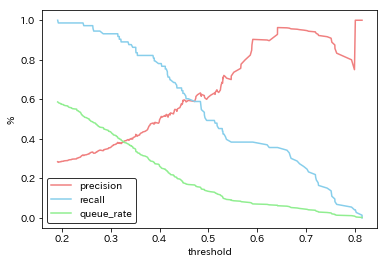

In [274]:
# 得られた最適パラメータを使ってモデル作成、AUCの表示
train_xd = lgb.Dataset(df_train_x, label=df_train_y, feature_name=train_columns, categorical_feature=cate_cols, weight=df_train_y * obj_weight + 1)
bst = lgb.train(best_params, train_xd)
pred_y = bst.predict(df_test_x)
auc_bst = metrics.roc_auc_score(df_test_y, pred_y)
print(auc_bst)

# 最適なF値の探索と可視化
# F値の上位5つくらいを列挙
list_threshold_fscore = [[i * 0.01, metrics.f1_score(df_test_y, preprocessing.binarize(X=pred_y.reshape(1, -1), threshold=(i * 0.01))[0],)] for i in range(100)]
df_threshold_fscore = pd.DataFrame(list_threshold_fscore, columns=["threshold", "score"])
df_threshold_fscore_head = df_threshold_fscore.sort_values(by=["score", "threshold"], ascending=[False, True]).head()
print(df_threshold_fscore_head)
max_f1 = df_threshold_fscore_head["score"].values[0]
optimal_threshold = df_threshold_fscore_head["threshold"].values[0]
print("Max F1 Score: " +  str(max_f1) + "  (Threshold = " +  str(optimal_threshold) + ")")

# 混合行列作成
pred_y_binary = pred_y.copy()
pred_y_binary[pred_y_binary >= optimal_threshold] = 1
pred_y_binary[pred_y_binary < optimal_threshold] = 0
print(metrics.confusion_matrix(df_test_y, pred_y_binary))

# Precisionとか計算
print("Precision:", metrics.precision_score(df_test_y, pred_y_binary))
print("Recall:", metrics.recall_score(df_test_y, pred_y_binary))

# Precisionとかの可視化
precision, recall, thresholds = metrics.precision_recall_curve(df_test_y, pred_y)
thresholds = np.append(thresholds, max(thresholds))
queue_rate = [(pred_y >= threshold).mean() for threshold in thresholds]
plt.plot(thresholds, precision, color="lightcoral")
plt.plot(thresholds, recall, color="skyblue")
plt.plot(thresholds, queue_rate, color="lightgreen")
leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%')

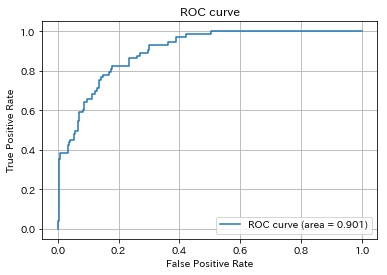

In [275]:
from sklearn import metrics as mtr
fpr, tpr, thresholds = metrics.roc_curve(df_test_y, pred_y)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Feature Importances:


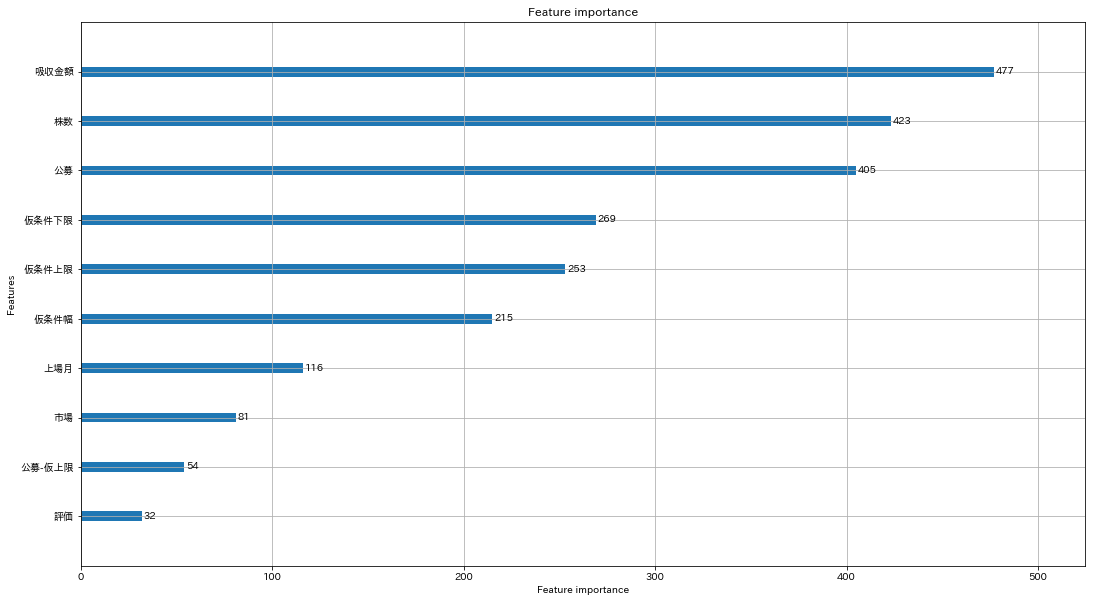

In [276]:
print('Feature Importances:')
lgb.plot_importance(bst,figsize=(18,10))
display()

In [277]:
prediction = df_test_x.copy()
prediction["危険"] = pred_y
prediction["実際"] = df_test_y

In [282]:
print(prediction.query('危険 <= 0.41').sort_values("危険",ascending=False))

     市場      公募     吸収金額  評価  主幹事数 上場月   仮条件下限   仮条件上限   仮条件幅  公募-仮上限  \
code                                                                    
7673  4    1540     9.60   5     1   2    1510    1540     30       0   
2820  1    1690    20.70   6     1   5    1650    1690     40       0   
1451  4     850    14.90   9     1   2     800     850     50       0   
3478  2  143000   451.00   6     1   1  133000  143000  10000       0   
1438  2    1150     5.29   6     1  10    1000    1150    150       0   
3298  2  103000   444.00   3     2   5  100000  103000   3000       0   
3296  2  252000   381.00   3     1   3  248000  252000   4000       0   
4124  1    1860    11.30   3     1   9    1830    1860     30       0   
3688  5    2400   104.00   1     1   6    2200    2400    200       0   
6564  2    1300     4.96   3     1  11    1200    1300    100       0   
3994  5    1550    45.40   6     1   8    1350    1550    200       0   
7047  5    1480    54.30   5     1  11    1420    1

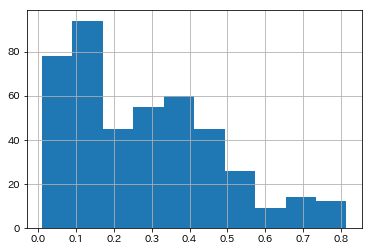

In [279]:
prediction["危険"].hist(bins =10)

In [281]:
313/330

0.9484848484848485